In [ ]:
!pip install -q sentencepiece sacrebleu

from google.colab import drive
drive.mount('/content/drive')

import math, random, os, time
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import sacrebleu
import matplotlib.pyplot as plt

Mounted at /content/drive


# Preprocessing & Tokenization

In [ ]:
# ---------- Paths & basic config ----------
DATA_DIR = Path("/content/drive/MyDrive/DL Final Project/data/europarl")
SPM_MODEL = DATA_DIR / "spm_bpe.model"
VOCAB_SIZE = 16000
MAX_LEN = 120
BATCH_SIZE = 256
NUM_EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [ ]:
# ---------- Train/load SentencePiece tokenizer ----------
if not SPM_MODEL.exists():
    print("Training SentencePiece tokenizer...")
    input_files = [
        str(DATA_DIR / "train.src"),
        str(DATA_DIR / "train.tgt")
    ]
    spm.SentencePieceTrainer.Train(
        input=",".join(input_files),
        model_prefix=str(DATA_DIR / "spm_bpe"),
        vocab_size=VOCAB_SIZE,
        character_coverage=1.0,
        model_type="bpe",
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3
    )
    print("SentencePiece trained.")

sp = spm.SentencePieceProcessor()
sp.load(str(SPM_MODEL))

PAD = sp.pad_id()
BOS = sp.bos_id()
EOS = sp.eos_id()
UNK = sp.unk_id()
VOCAB = sp.get_piece_size()

print(f"Vocab size: {VOCAB}, PAD={PAD}, BOS={BOS}, EOS={EOS}, UNK={UNK}")

Vocab size: 8000, PAD=0, BOS=1, EOS=2, UNK=3


In [ ]:
# ---------- Dataset & DataLoader ----------

class SPMDataset(Dataset):
    """
    Reads raw text files (one sentence per line) and encodes on the fly with SentencePiece.
    """
    def __init__(self, src_file, tgt_file, max_len=120):
        self.src_lines = (DATA_DIR/src_file).read_text(encoding="utf-8").splitlines()
        self.tgt_lines = (DATA_DIR/tgt_file).read_text(encoding="utf-8").splitlines()
        assert len(self.src_lines) == len(self.tgt_lines)
        self.max_len = max_len

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = self.src_lines[idx].strip()
        tgt = self.tgt_lines[idx].strip()

        src_ids = [BOS] + sp.encode(src, out_type=int)[:self.max_len-2] + [EOS]
        tgt_ids = [BOS] + sp.encode(tgt, out_type=int)[:self.max_len-2] + [EOS]

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_batch(batch):
    src_seqs, tgt_seqs = zip(*batch)
    src_lens = [len(s) for s in src_seqs]
    tgt_lens = [len(t) for t in tgt_seqs]
    max_src = max(src_lens)
    max_tgt = max(tgt_lens)

    B = len(batch)
    src_pad = torch.full((B, max_src), PAD, dtype=torch.long)
    tgt_pad = torch.full((B, max_tgt), PAD, dtype=torch.long)

    for i, (s, t) in enumerate(zip(src_seqs, tgt_seqs)):
        src_pad[i, :len(s)] = s
        tgt_pad[i, :len(t)] = t

    return src_pad, tgt_pad

train_ds = SPMDataset("train.src", "train.tgt", max_len=MAX_LEN)
val_ds   = SPMDataset("val.src",   "val.tgt",   max_len=MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=collate_batch, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      collate_fn=collate_batch, num_workers=2, pin_memory=True)

print("Train size:", len(train_ds), "Val size:", len(val_ds))


Train size: 1524504 Val size: 190563


# Transformer model

In [ ]:
# ---------- Transformer model ----------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, T, D]
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerMT(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=512,        # keep 512
        nhead=8,
        num_encoder_layers=6,   # was 4
        num_decoder_layers=6,   # was 4
        dim_feedforward=2048,   # was 1024
        dropout=0.1,
    ):
        super().__init__()
        self.d_model = d_model

        self.src_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.tgt_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # => [B, T, D]
        )
        self.out = nn.Linear(d_model, vocab_size)

    def _generate_subsequent_mask(self, size, device):
        # standard causal mask
        return torch.triu(
            torch.full((size, size), float("-inf"), device=device), diagonal=1
        )

    def forward(self, src, tgt_inp):
        """
        src:     [B, S]
        tgt_inp: [B, T] (decoder inputs, shifted right)
        """
        src_key_padding_mask = (src == PAD)   # [B,S]
        tgt_key_padding_mask = (tgt_inp == PAD)

        src_emb = self.pos_encoder(self.src_embed(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_decoder(self.tgt_embed(tgt_inp) * math.sqrt(self.d_model))

        tgt_len = tgt_inp.size(1)
        tgt_mask = self._generate_subsequent_mask(tgt_len, src.device)

        out = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
        )
        logits = self.out(out)  # [B, T, V]
        return logits

    @torch.no_grad()
    def greedy_decode(self, src, max_len=MAX_LEN, bos_id=BOS, eos_id=EOS):
        """
        src: [1, S] tensor
        Returns: [1, T] generated ids (including BOS/EOS)
        """
        self.eval()
        device = src.device

        src_key_padding_mask = (src == PAD)
        src_emb = self.pos_encoder(self.src_embed(src) * math.sqrt(self.d_model))
        memory = self.transformer.encoder(
            src_emb,
            src_key_padding_mask=src_key_padding_mask,
        )

        ys = torch.tensor([[bos_id]], dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            tgt_emb = self.pos_decoder(self.tgt_embed(ys) * math.sqrt(self.d_model))
            tgt_mask = self._generate_subsequent_mask(ys.size(1), device)
            out = self.transformer.decoder(
                tgt=tgt_emb,
                memory=memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=(ys == PAD),
                memory_key_padding_mask=src_key_padding_mask,
            )
            logits = self.out(out[:, -1])  # [1, V]
            next_token = logits.argmax(dim=-1).unsqueeze(1)  # [1,1]
            ys = torch.cat([ys, next_token], dim=1)
            if next_token.item() == eos_id:
                break
        return ys

#  Training and Validation

In [ ]:
# ---------- Training loop with loss + perplexity tracking ----------

model = TransformerMT(VOCAB).to(DEVICE)
print("Model params:", sum(p.numel() for p in model.parameters())/1e6, "M")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.98), weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
}

def run_epoch(dl, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n_batches = 0

    for src, tgt in dl:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # teacher forcing: decoder input is BOS..last-1, target is 2..end
        tgt_inp = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        logits = model(src, tgt_inp)     # [B, T-1, V]
        loss = loss_fn(
            logits.reshape(-1, VOCAB),
            tgt_out.reshape(-1)
        )

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / n_batches
    ppl = math.exp(min(avg_loss, 20))   # clamp to avoid overflow
    return avg_loss, ppl

best_val_loss = float("inf")
CKPT_PATH = "/content/transformer_europarl_best.pt"

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{NUM_EPOCHS} =====")

    train_loss, train_ppl = run_epoch(train_dl, train=True)
    val_loss,   val_ppl   = run_epoch(val_dl,   train=False)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)

    print(f"Train loss: {train_loss:.4f}, ppl: {train_ppl:.2f}")
    print(f"Val   loss: {val_loss:.4f}, ppl: {val_ppl:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CKPT_PATH)
        print(f"  -> New best model saved to {CKPT_PATH}")

Model params: 56.436544 M

===== Epoch 1/10 =====


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Train loss: 3.7419, ppl: 42.18
Val   loss: 2.6039, ppl: 13.52
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 2/10 =====
Train loss: 2.4322, ppl: 11.38
Val   loss: 2.0906, ppl: 8.09
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 3/10 =====
Train loss: 2.1281, ppl: 8.40
Val   loss: 1.8840, ppl: 6.58
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 4/10 =====
Train loss: 1.9707, ppl: 7.18
Val   loss: 1.7569, ppl: 5.79
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 5/10 =====
Train loss: 1.8660, ppl: 6.46
Val   loss: 1.6678, ppl: 5.30
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 6/10 =====
Train loss: 1.7862, ppl: 5.97
Val   loss: 1.5993, ppl: 4.95
  -> New best model saved to /content/transformer_europarl_best.pt

===== Epoch 7/10 =====
Train loss: 1.7216, ppl: 5.59
Val   loss: 1.5375, ppl: 4.65
  -> New best model saved to /c

In [ ]:
# Save history for later plotting
torch.save(history, "/content/drive/MyDrive/DL Final Project/checkpoints/transformer_training_history.pt")
print("Training finished")

# Also save a copy into Drive so it doesn't vanish
CKPT_DIR = Path("/content/drive/MyDrive/DL Final Project/checkpoints")
CKPT_PATH = CKPT_DIR / "transformer_best.pt"
torch.save(model.state_dict(), CKPT_PATH)
print("Also saved to Drive:", CKPT_PATH)

Training finished
Also saved to Drive: /content/drive/MyDrive/DL Final Project/checkpoints/transformer_best.pt


# Evaluation

In [ ]:
CKPT_DIR = Path("/content/drive/MyDrive/DL Final Project/checkpoints")
CKPT_PATH = CKPT_DIR / "transformer_best.pt"

In [ ]:
# ========= FAST BASELINE BLEU EVALUATION (SUBSET) =========
import math
import sacrebleu

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading checkpoint from:", CKPT_PATH)
model = TransformerMT(VOCAB).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval()
print("Loaded Transformer model.\n")

def ids_to_text(ids):
    ids = [int(i) for i in ids]
    cleaned = [i for i in ids if i not in (PAD, BOS, EOS)]
    return sp.decode(cleaned) if cleaned else ""

# limit evaluation to a subset so it doesn't take forever
MAX_EVAL = 2000
count = 0
refs, hyps = [], []

print(f"Evaluating BLEU on at most {MAX_EVAL} validation sentences")

with torch.no_grad():
    for src, tgt in val_dl:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        for i in range(src.size(0)):
            if count >= MAX_EVAL:
                break

            src_i = src[i:i+1]
            tgt_i = tgt[i]

            gen = model.greedy_decode(src_i, max_len=MAX_LEN)[0]

            ref_text = ids_to_text(tgt_i.cpu().tolist())
            hyp_text = ids_to_text(gen.cpu().tolist())

            refs.append(ref_text)
            hyps.append(hyp_text)

            count += 1

        if count >= MAX_EVAL:
            break

print(f"evaluated on {count} sentences.")

bleu = sacrebleu.corpus_bleu(hyps, [refs])
print(f"\n Transformer BLEU score: {bleu.score:.2f}\n")

# ---- Show a few qualitative examples from this subset ----
print("Some qualitative examples from the validation subset:")
for i in range(min(5, len(hyps))):
    print(f"\nExample {i+1}")
    print("SRC:", val_ds.src_lines[i])
    print("REF:", refs[i])
    print("HYP:", hyps[i])


Loading checkpoint from: /content/drive/MyDrive/DL Final Project/checkpoints/transformer_best.pt
Loaded Transformer model.

Evaluating BLEU on at most 2000 validation sentences
evaluated on 2000 sentences.

 Transformer BLEU score: 28.85

Some qualitative examples from the validation subset:

Example 1
SRC: es ist also nicht erforderlich, das instrumentarium komplett neu zu gestalten.
REF: it is not therefore necessary to overhaul it completely.
HYP: it is therefore not necessary to completely reorganise the instruments.

Example 2
SRC: ich würde den staats- und regierungschefs sagen, dass dies ein großer fehler wäre.
REF: i would say to the heads of state or government that that would be a great error.
HYP: i would say to the heads of state or government that this would be a big mistake.

Example 3
SRC: es genügt nicht, die organe der eu dazu aufzurufen, auf der haager konferenz eine aktive rolle zu spielen, damit die verfahren für internationale adoptionen verbessert, rationalisiert 


Loading training history from: /content/drive/MyDrive/DL Final Project/checkpoints/transformer_training_history.pt


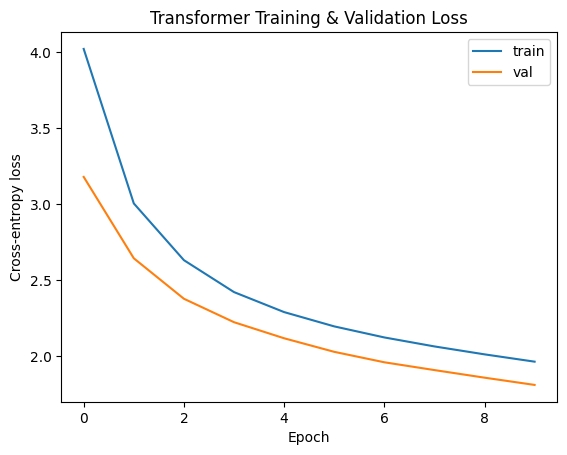

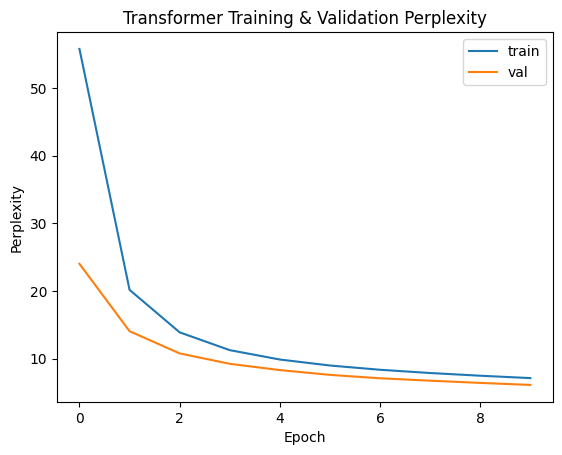

In [ ]:
# ========= LOAD & PLOT TRAINING HISTORY =========
from pathlib import Path
import matplotlib.pyplot as plt
import torch

CKPT_DIR = Path("/content/drive/MyDrive/DL Final Project/checkpoints")
HIST_PATH = CKPT_DIR / "transformer_training_history.pt"

print("\nLoading training history from:", HIST_PATH)
history = torch.load(HIST_PATH)

# Loss curves
plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Transformer Training & Validation Loss")
plt.legend()
plt.show()

# Perplexity curves
plt.figure()
plt.plot(history["train_ppl"], label="train")
plt.plot(history["val_ppl"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Transformer Training & Validation Perplexity")
plt.legend()
plt.show()

# Fine-tuning

new:

In [ ]:
# Reuse DEVICE, MAX_LEN, TransformerMT, val_dl, val_ds, etc. from above cells

DATA_DIR = Path("/content/drive/MyDrive/DL Final Project/data/europarl")
CKPT_DIR = Path("/content/drive/MyDrive/DL Final Project/checkpoints")

SPM_MODEL = DATA_DIR / "spm_bpe.model"
BASE_CKPT = CKPT_DIR / "transformer_best.pt"
FT_CKPT   = CKPT_DIR / "transformer_finetuned.pt"
FT_HIST_PATH = CKPT_DIR / "transformer_finetune_history.pt"

# ---- reload tokenizer to be safe (same model as before) ----
sp = spm.SentencePieceProcessor()
sp.load(str(SPM_MODEL))

PAD = sp.pad_id()
BOS = sp.bos_id()
EOS = sp.eos_id()
VOCAB = sp.get_piece_size()

print("PAD, BOS, EOS, UNK:", PAD, BOS, EOS, sp.unk_id())
print("Vocab size:", VOCAB)

def ids_to_text(ids):
    ids = [int(i) for i in ids]
    cleaned = [i for i in ids if i not in (PAD, BOS, EOS)]
    return sp.decode(cleaned) if cleaned else ""

# ---- reload baseline model for fine-tuning ----
print("\nReloading baseline checkpoint BEFORE fine-tuning...")
model = TransformerMT(VOCAB).to(DEVICE)
model.load_state_dict(torch.load(BASE_CKPT, map_location=DEVICE))
model.train()
print("Loaded baseline model for fine-tuning from:", BASE_CKPT)

PAD, BOS, EOS, UNK: 0 1 2 3
Vocab size: 8000

Reloading baseline checkpoint BEFORE fine-tuning...
Loaded baseline model for fine-tuning from: /content/drive/MyDrive/DL Final Project/checkpoints/transformer_best.pt


In [ ]:
# ---------------------------------------------------------
# Helper: compute BLEU on a subset of validation sentences
# ---------------------------------------------------------
def compute_bleu(model, max_eval=2000):
    model.eval()
    refs, hyps = [], []
    count = 0

    with torch.no_grad():
        for src, tgt in val_dl:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)

            for i in range(src.size(0)):
                if count >= max_eval:
                    break
                src_i = src[i:i+1]
                tgt_i = tgt[i]

                gen = model.greedy_decode(src_i, max_len=MAX_LEN)[0]
                ref_text = ids_to_text(tgt_i.cpu().tolist())
                hyp_text = ids_to_text(gen.cpu().tolist())

                refs.append(ref_text)
                hyps.append(hyp_text)
                count += 1
            if count >= max_eval:
                break

    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    return bleu.score, count

# ---------------------------------------------------------
# Check BLEU of baseline (before any fine-tuning)
# ---------------------------------------------------------
base_bleu, base_n = compute_bleu(model, max_eval=2000)
print(f"\nBaseline Transformer BLEU (before fine-tuning): {base_bleu:.2f} on {base_n} sentences\n")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



Baseline Transformer BLEU (before fine-tuning): 19.15 on 2000 sentences



In [ ]:
# ---------------------------------------------------------
# Fine-tuning setup
# ---------------------------------------------------------
FT_NUM_EPOCHS = 5          # you can try 3–5 depending on time
FT_LR_ENCODER = 5e-5
FT_LR_DECODER = 3e-4

loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

# separate encoder vs decoder/out parameters for different LRs
enc_params = list(model.src_embed.parameters()) + \
             list(model.transformer.encoder.parameters())
dec_params = list(model.tgt_embed.parameters()) + \
             list(model.transformer.decoder.parameters()) + \
             list(model.out.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": enc_params, "lr": FT_LR_ENCODER},
        {"params": dec_params, "lr": FT_LR_DECODER},
    ],
    betas=(0.9, 0.98),
    weight_decay=0.0  # no weight decay during fine-tuning
)

ft_history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
    "val_bleu": []
}

def run_epoch(dl, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, n_batches = 0.0, 0

    for src, tgt in dl:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_inp = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        logits = model(src, tgt_inp)
        loss = loss_fn(
            logits.reshape(-1, VOCAB),
            tgt_out.reshape(-1)
        )

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / n_batches
    ppl = math.exp(min(avg_loss, 20))
    return avg_loss, ppl

In [ ]:
# ---------------------------------------------------------
# Fine-tuning loop (select best model by BLEU)
# ---------------------------------------------------------
best_bleu = base_bleu
best_epoch = 0

print("===== FINE-TUNING Transformer (selecting by BLEU) =====")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{FT_NUM_EPOCHS}")

    train_loss, train_ppl = run_epoch(train_dl, train=True)
    val_loss,   val_ppl   = run_epoch(val_dl,   train=False)
    val_bleu,   val_n     = compute_bleu(model, max_eval=2000)

    ft_history["train_loss"].append(train_loss)
    ft_history["val_loss"].append(val_loss)
    ft_history["train_ppl"].append(train_ppl)
    ft_history["val_ppl"].append(val_ppl)
    ft_history["val_bleu"].append(val_bleu)

    print(f"  Train loss: {train_loss:.4f}, ppl: {train_ppl:.2f}")
    print(f"  Val   loss: {val_loss:.4f}, ppl: {val_ppl:.2f}")
    print(f"  Val   BLEU: {val_bleu:.2f} (on {val_n} sentences)")

    # keep checkpoint with best BLEU (not just lowest loss)
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        best_epoch = epoch
        torch.save(model.state_dict(), FT_CKPT)
        print(f"  -> New best BLEU! Saved fine-tuned model to {FT_CKPT}")

print(f"\nFine-tuning finished. Best BLEU = {best_bleu:.2f} at epoch {best_epoch}")
torch.save(ft_history, FT_HIST_PATH)
print("Fine-tuning history saved to:", FT_HIST_PATH)


===== FINE-TUNING Transformer (selecting by BLEU) =====

Epoch 1/5
  Train loss: 1.9011, ppl: 6.69
  Val   loss: 1.7515, ppl: 5.76
  Val   BLEU: 20.01 (on 2000 sentences)
  -> New best BLEU! Saved fine-tuned model to /content/drive/MyDrive/DL Final Project/checkpoints/transformer_finetuned.pt

Epoch 2/5
  Train loss: 1.8722, ppl: 6.50
  Val   loss: 1.7313, ppl: 5.65
  Val   BLEU: 20.39 (on 2000 sentences)
  -> New best BLEU! Saved fine-tuned model to /content/drive/MyDrive/DL Final Project/checkpoints/transformer_finetuned.pt

Epoch 3/5
  Train loss: 1.8500, ppl: 6.36
  Val   loss: 1.7116, ppl: 5.54
  Val   BLEU: 20.72 (on 2000 sentences)
  -> New best BLEU! Saved fine-tuned model to /content/drive/MyDrive/DL Final Project/checkpoints/transformer_finetuned.pt

Epoch 4/5
  Train loss: 1.8307, ppl: 6.24
  Val   loss: 1.6940, ppl: 5.44
  Val   BLEU: 20.96 (on 2000 sentences)
  -> New best BLEU! Saved fine-tuned model to /content/drive/MyDrive/DL Final Project/checkpoints/transformer_finet

In [ ]:
# ---------------------------------------------------------
# Evaluate the BEST fine-tuned checkpoint one more time
# ---------------------------------------------------------
print("\nLoading best fine-tuned checkpoint from:", FT_CKPT)
model = TransformerMT(VOCAB).to(DEVICE)
state_dict = torch.load(str(FT_CKPT), map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

final_bleu, final_n = compute_bleu(model, max_eval=2000)
print(f"\nFinal Fine-tuned Transformer BLEU: {final_bleu:.2f} on {final_n} sentences\n")

print("===== Sample qualitative examples (Fine-tuned model) =====")
num_examples = 5
refs_ft, hyps_ft = [], []
count = 0

with torch.no_grad():
    for src, tgt in val_dl:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        for i in range(src.size(0)):
            if count >= num_examples:
                break
            src_i = src[i:i+1]
            tgt_i = tgt[i]

            gen = model.greedy_decode(src_i, max_len=MAX_LEN)[0]
            ref_text = ids_to_text(tgt_i.cpu().tolist())
            hyp_text = ids_to_text(gen.cpu().tolist())

            refs_ft.append(ref_text)
            hyps_ft.append(hyp_text)
            count += 1
        if count >= num_examples:
            break

for i in range(num_examples):
    print(f"\nExample {i+1}")
    print("SRC:", val_ds.src_lines[i])
    print("REF:", refs_ft[i])
    print("HYP:", hyps_ft[i])


Loading best fine-tuned checkpoint from: /content/drive/MyDrive/DL Final Project/checkpoints/transformer_finetuned.pt

Final Fine-tuned Transformer BLEU: 21.29 on 2000 sentences

===== Sample qualitative examples (Fine-tuned model) =====

Example 1
SRC: es ist also nicht erforderlich, das instrumentarium komplett neu zu gestalten.
REF: it is not therefore necessary to overhaul it completely.
HYP: it is therefore not necessary to re-establish the whole instrument.

Example 2
SRC: ich würde den staats- und regierungschefs sagen, dass dies ein großer fehler wäre.
REF: i would say to the heads of state or government that that would be a great error.
HYP: i would say that this would be a big mistake by the heads of state or government.

Example 3
SRC: es genügt nicht, die organe der eu dazu aufzurufen, auf der haager konferenz eine aktive rolle zu spielen, damit die verfahren für internationale adoptionen verbessert, rationalisiert und vereinfacht werden.
REF: it is not enough to call on e

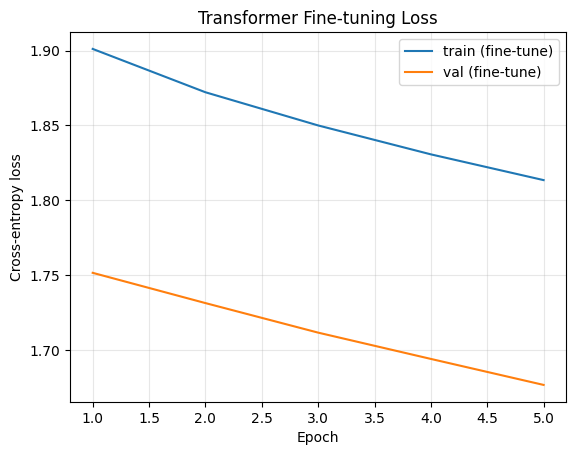

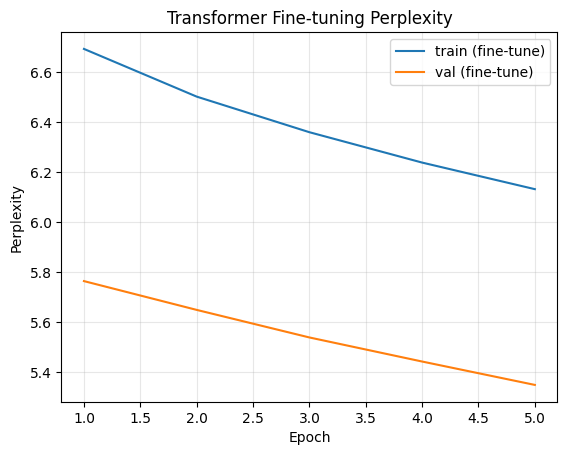

In [ ]:
CKPT_DIR = Path("/content/drive/MyDrive/DL Final Project/checkpoints")
MAIN_HIST_PATH = CKPT_DIR / "transformer_training_history.pt"
FT_HIST_PATH   = CKPT_DIR / "transformer_finetune_history.pt"

# Load histories
main_hist = torch.load(MAIN_HIST_PATH)   # from main training
ft_hist   = torch.load(FT_HIST_PATH)     # from fine-tuning

# -----------------------------
# 1) Fine-tuning only plots
# -----------------------------
epochs_ft = range(1, len(ft_hist["train_loss"]) + 1)

# Loss
plt.figure()
plt.plot(epochs_ft, ft_hist["train_loss"], label="train (fine-tune)")
plt.plot(epochs_ft, ft_hist["val_loss"],   label="val (fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Transformer Fine-tuning Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Perplexity
plt.figure()
plt.plot(epochs_ft, ft_hist["train_ppl"], label="train (fine-tune)")
plt.plot(epochs_ft, ft_hist["val_ppl"],   label="val (fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Transformer Fine-tuning Perplexity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


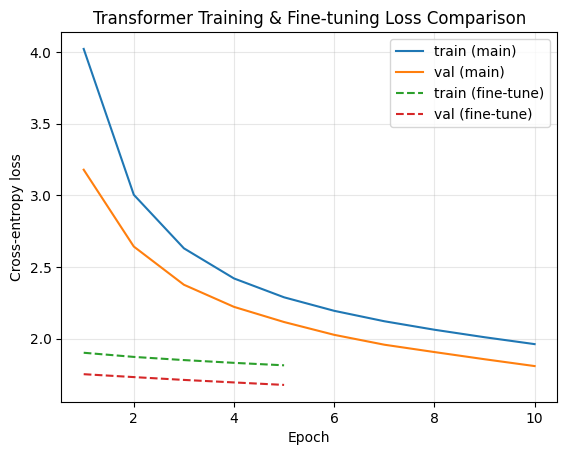

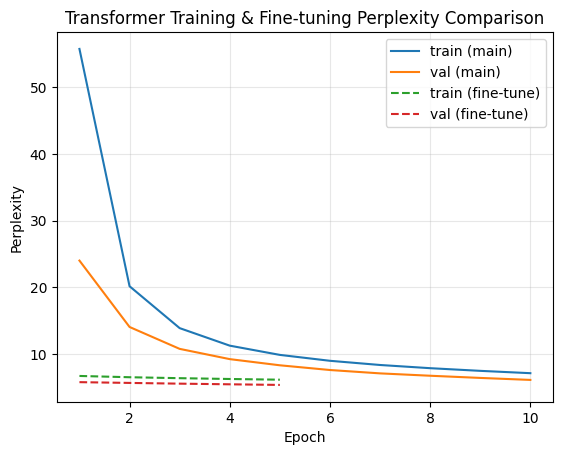

In [ ]:
# -----------------------------
# 2) Main vs Fine-tune overlay
# -----------------------------
epochs_main = range(1, len(main_hist["train_loss"]) + 1)

# Loss curves
plt.figure()
plt.plot(epochs_main, main_hist["train_loss"], label="train (main)")
plt.plot(epochs_main, main_hist["val_loss"],   label="val (main)")
plt.plot(epochs_ft,   ft_hist["train_loss"],   "--", label="train (fine-tune)")
plt.plot(epochs_ft,   ft_hist["val_loss"],     "--", label="val (fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Transformer Training & Fine-tuning Loss Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Perplexity curves
plt.figure()
plt.plot(epochs_main, main_hist["train_ppl"], label="train (main)")
plt.plot(epochs_main, main_hist["val_ppl"],   label="val (main)")
plt.plot(epochs_ft,   ft_hist["train_ppl"],   "--", label="train (fine-tune)")
plt.plot(epochs_ft,   ft_hist["val_ppl"],     "--", label="val (fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Transformer Training & Fine-tuning Perplexity Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

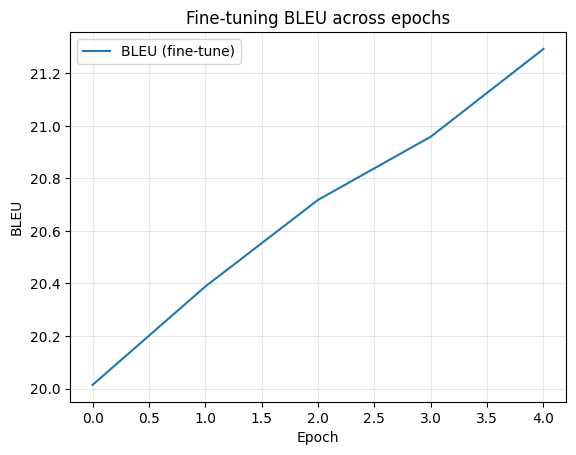

In [ ]:
plt.figure()
plt.plot(ft_hist["val_bleu"], label="BLEU (fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.title("Fine-tuning BLEU across epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()